# Cartesian Slepian Sequences

What follows is an implementation of what is described in [Simons and Wang (2011) "Spatiospectral Concentration in the Cartesian Plane"](https://link.springer.com/article/10.1007/s13137-011-0016-z). While the authors provide [Matlab codes](https://github.com/csdms-contrib/) to compute functions with general spatiospectral characteristics, we implement here a special case, that is, the case in which one has a convex, mirror-symmetric support in d-dimensional space, and a spherical support in d-dimensional spectral space. 

This particular implementation gives the option of using HODLR matrices (via the [KernelMatrices.jl](https://bitbucket.org/cgeoga/KernelMatrices.jl) package) to compute the kernel function and factorize it efficiently. This is one of the ways in which we believe this implementation improves upon the original work. 

## Background

If you are not familiar with the one-dimensional case in which one seeks to simultaneously constrain the spectral and spatial support of a function (that is, a function and its magnitude squared Fourier transform), the [1978 paper of Slepian](https://onlinelibrary.wiley.com/doi/abs/10.1002/j.1538-7305.1978.tb02104.x) shows the discrete case. In this notebook, we generalize to multiple dimensions. While we will only show visualizable 2 and 3-dimensional examples, the following code is dimension-agnostic. 

In spaces with dimension $d>2$, let $\mathcal{R} \subset \mathbb{R}^d$ be a region in space, and let $\mathcal{K}$ be a spherical region in the spectral domain. Then it turns out that the optimization problem in which we seek a function $v(\mathbf{x})$ whose Fourier transform is strictly supported on the set $\mathcal{K}$ while being constrained to live in the set $\mathcal{R}$ can be stated as a Fredholm integral equation of the second kind
$$ \int_{\mathcal{R}} D(\mathbf{x}, \mathbf{x}') v(\mathbf{x}) d \mathbf{x}' = \lambda v(\mathbf{x}) $$
where
$$ D(\mathbf{x}, \mathbf{x}') = \frac{K J_1(K ||\mathbf{x} - \mathbf{x}'||)}{2 \pi ||\mathbf{x} - \mathbf{x}'||} $$
That is, we get a number of eigenfunctions which solve the integral equation and thus span the space of optimally space and spectrally limited functions. It is the case in the 1D problem that there are only a small number of solutions having large eigenvalues. Note that by changing the kernel, one could effect different spectral responses. We find the spherical case to be most useful for practical purposes, and thus it is used for illustration. 

To solve the integral equation, one proceeds using the Nystrom method for solving Fredholm equations of the second kind, e.g. section 19.1 of [Press, 1992](http://nrbook.com/). This involves the use of numerical integration, which is accomplished here using [Gaussian Quadrature](https://juliaapproximation.github.io/FastGaussQuadrature.jl/stable/) in Julia. Gaussian quadrature introduces nodes and weights on the line from $(-1, 1)$ which turn the integration in each dimension into a sum. Simons and Wang describe the two dimensional scaling of the quadrature nodes in each dimension so as to fill the space $\mathcal{R}$, yielding a nested sum. Provided the kernel is smooth enough, the sum approximates the integral and one obtains the solution to the eigenvalue problem at the (unequally spaced) quadrature nodes. To re-interpolate to a regular grid, one substitutes back into the original formula.

In general, the larger the number of quadrature nodes selected, the better the approximation to the result, however this usually results in long computation times. To ease the computational burden, one can choose a (much) smaller number of quadrature nodes in each dimension than is actually needed, and use the reinterpolation step to scale up from there. Press suggests that the numerical integration error can be compared with the distance between the result of computing the desired eigenvalues twice, the second time using 50% more quadrature nodes. One can also make use of [KernelMatrices.jl](https://bitbucket.org/cgeoga/kernelmatrices.jl/src/master/), which approximates the kernel matrix by introducing submatrices having lower rank. This greatly simplifies the calculation, but can introduce additional error. 

In [1]:
using Slepians, FastGaussQuadrature
using Plots, FFTW

┌ Info: Precompiling Slepians [97caf2bd-9cc0-4738-8821-c8999f46f3c9]
└ @ Base loading.jl:1278
┌ Warning: Package Slepians does not have Statistics in its dependencies:
│ - If you have Slepians checked out for development and have
│   added Statistics as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with Slepians
└ Loading Statistics into Slepians from project dependency, future warnings for Slepians are suppressed.


## Example 1: Rectangular support in space

By default, if one does not input one's own quadrature nodes, rectangular support in space is assumed.

In [2]:
@time s_exact, sleps_exact = customsleps(5, 10.0, (32, 35, 36), exact = true);

397.900442 seconds (12.58 M allocations: 25.088 GiB, 0.12% gc time)


In [3]:
# One can also run this example using an approximation, for speed (though for small examples, exact is faster)
@time s_hodlr, sleps_hodlr = customsleps(5, 10.0, (32, 35, 36), maxrank=256, exact = false);

101.818060 seconds (53.25 M allocations: 192.215 GiB, 10.67% gc time)


In [17]:
Slep = map(v->fftshift(abs2.(fft(v))), sleps_exact);

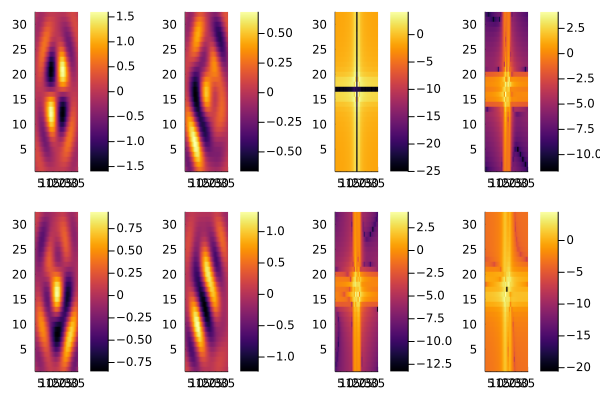

In [18]:
h1 = heatmap(real.(sleps_exact[1][:,:,13]))
h2 = heatmap(real.(sleps_exact[2][:,:,13]))
h3 = heatmap(real.(sleps_exact[3][:,:,13]))
h4 = heatmap(real.(sleps_exact[4][:,:,13]))

H1 = heatmap(log10.(Slep[1][:,:,13]))
H2 = heatmap(log10.(Slep[2][:,:,13]))
H3 = heatmap(log10.(Slep[3][:,:,13]))
H4 = heatmap(log10.(Slep[4][:,:,13]))

plot(h1, h2, H1, H2, h3, h4, H3, H4, layout = (2,4))

## Example 2 - Convex region in space

Here we use an octagonal support in 2D and create our own quadrature nodes and weights. This is then passed to the same function to compute the optimal tapers. 

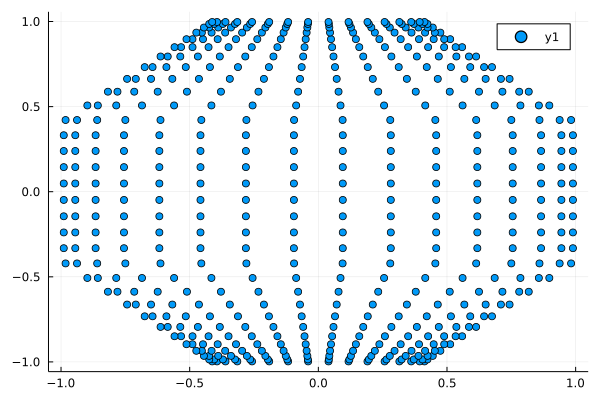

In [6]:
# This lower boundary describes an octagon
lbfun(x) = (x>=0)*max(-sqrt(2)+x, -1) + (x<0)*max(-sqrt(2)-x,-1)

# Create quadrature nodes and weights for each dimension:
M = 4; Kp = 10.0; szs = (32, 16)
nowtv = getnodeswts(szs)
no    = [(lbfun(x)*y, x) for x in nowtv[1][1] for y in nowtv[2][1]]
scatter(no)

In [7]:
@time s, sleps = customsleps(M, Kp, szs, no = no, sqwt = givewts(nowtv), exact = false);

  1.701457 seconds (5.06 M allocations: 358.902 MiB, 5.20% gc time)


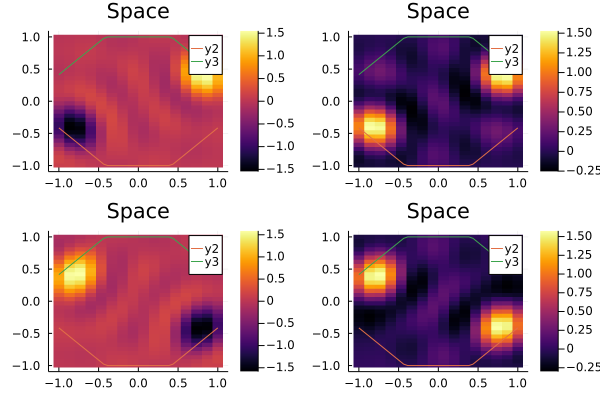

In [8]:
""" This function adds the visual boundary """
function addbdy(h)
    plot!(h,t -> lbfun(t), LinRange(-1,1, 40))
    plot!(h,t -> -lbfun(t), LinRange(-1,1, 40))
    return h
end

h1 = heatmap(range(-1.0, 1.0, length=szs[2]),range(-1.0, 1.0, length=szs[1]),real.(sleps[1]))
h2 = heatmap(range(-1.0, 1.0, length=szs[2]),range(-1.0, 1.0, length=szs[1]),real.(sleps[2]))
h3 = heatmap(range(-1.0, 1.0, length=szs[2]),range(-1.0, 1.0, length=szs[1]),real.(sleps[3]))
h4 = heatmap(range(-1.0, 1.0, length=szs[2]),range(-1.0, 1.0, length=szs[1]),real.(sleps[4]))

h1 = addbdy(h1)
h2 = addbdy(h2)
h3 = addbdy(h3)
h4 = addbdy(h4)

plot(h1, h2, h3, h4, layout = (2,2), title = "Space")

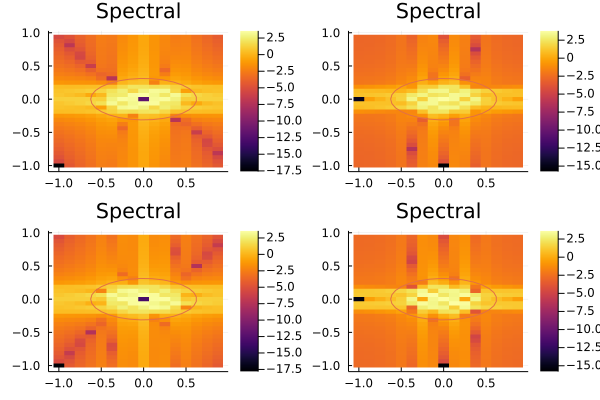

In [9]:
H1 = heatmap(range(-1.0, 1.0, length=szs[2]+1)[1:szs[2]],range(-1.0, 1.0, length=szs[1]+1)[1:szs[1]],
    log10.(fftshift(abs2.(fft(sleps[1])))))
H2 = heatmap(range(-1.0, 1.0, length=szs[2]+1)[1:szs[2]],range(-1.0, 1.0, length=szs[1]+1)[1:szs[1]],
    log10.(fftshift(abs2.(fft(sleps[2])))))
H3 = heatmap(range(-1.0, 1.0, length=szs[2]+1)[1:szs[2]],range(-1.0, 1.0, length=szs[1]+1)[1:szs[1]],
    log10.(fftshift(abs2.(fft(sleps[3])))))
H4 = heatmap(range(-1.0, 1.0, length=szs[2]+1)[1:szs[2]],range(-1.0, 1.0, length=szs[1]+1)[1:szs[1]],
    log10.(fftshift(abs2.(fft(sleps[4])))))

plot!(H1, (Kp/16)*cos.(range(-pi, pi, length=30)), (Kp/32)*sin.(range(-pi, pi, length=30)))
plot!(H2, (Kp/16)*cos.(range(-pi, pi, length=30)), (Kp/32)*sin.(range(-pi, pi, length=30)))
plot!(H3, (Kp/16)*cos.(range(-pi, pi, length=30)), (Kp/32)*sin.(range(-pi, pi, length=30)))
plot!(H4, (Kp/16)*cos.(range(-pi, pi, length=30)), (Kp/32)*sin.(range(-pi, pi, length=30)))

plot(H1, H2, H3, H4, layout = (2,2), title = "Spectral", legend = false)

## 3D Octagonal Prism

Extending into the third dimension, we can add more nodes. As mentioned before, this code will work in higher dimensions as well. 

In [2]:
M = 4; Kp = 10.0; szs = (32,32,32)
int = (1001, 1001, 1001)
nowtv = [FastGaussQuadrature.gausslegendre(nj) for nj in szs]

lbfun(x) = (x>=0)*max(-sqrt(2)+x, -1) + (x<0)*max(-sqrt(2)-x,-1)

no    = [(x, lbfun(x)*y, z) for x in nowtv[1][1] for y in nowtv[2][1] for z in nowtv[3][1]]

32768-element Array{Tuple{Float64,Float64,Float64},1}:
 (-0.9972638618494816, 0.41580886854116367, -0.9972638618494816)
 (-0.9972638618494816, 0.41580886854116367, -0.9856115115452684)
 (-0.9972638618494816, 0.41580886854116367, -0.9647622555875064)
 (-0.9972638618494816, 0.41580886854116367, -0.9349060759377397)
 (-0.9972638618494816, 0.41580886854116367, -0.8963211557660521)
 (-0.9972638618494816, 0.41580886854116367, -0.84936761373257)
 (-0.9972638618494816, 0.41580886854116367, -0.7944837959679424)
 (-0.9972638618494816, 0.41580886854116367, -0.7321821187402897)
 (-0.9972638618494816, 0.41580886854116367, -0.6630442669302152)
 (-0.9972638618494816, 0.41580886854116367, -0.5877157572407623)
 (-0.9972638618494816, 0.41580886854116367, -0.5068999089322294)
 (-0.9972638618494816, 0.41580886854116367, -0.42135127613063533)
 (-0.9972638618494816, 0.41580886854116367, -0.33186860228212767)
 ⋮
 (0.9972638618494816, -0.41580886854116367, 0.42135127613063533)
 (0.9972638618494816, -0.4158088

In [ ]:
scatter(no, camera = (60, 60))

In [ ]:
# Compute the Slepians on this basis
@time s, sleps = customsleps(M, Kp, szs, no = no, sqwt = givewts(nowtv), int = int, exact = false);

In [ ]:
using JLD
save("bigsleps.jld", "s", t, "sleps", sleps)


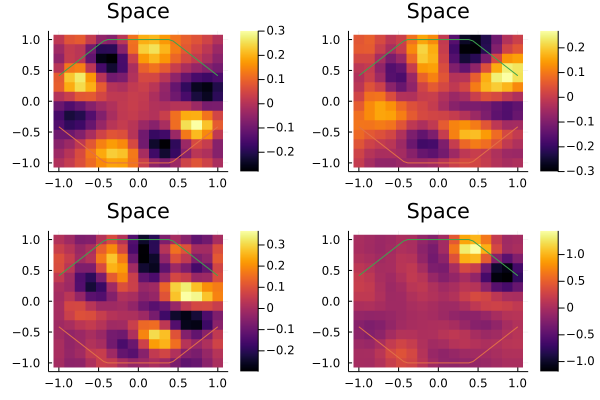

In [13]:
h9 = heatmap(range(-1.0, 1.0, length=szs[2]),range(-1.0, 1.0, length=szs[1]),real.(sleps[1][:,:,9]))
h7 = heatmap(range(-1.0, 1.0, length=szs[2]),range(-1.0, 1.0, length=szs[1]),real.(sleps[1][:,:,7]))
h5 = heatmap(range(-1.0, 1.0, length=szs[2]),range(-1.0, 1.0, length=szs[1]),real.(sleps[1][:,:,5]))
h3 = heatmap(range(-1.0, 1.0, length=szs[2]),range(-1.0, 1.0, length=szs[1]),real.(sleps[1][:,:,3]))

h9 = addbdy(h9)
h7 = addbdy(h7)
h5 = addbdy(h5)
h3 = addbdy(h3)

plot(h9, h7, h5, h3, layout=(2,2), title = "Space", legend = false)

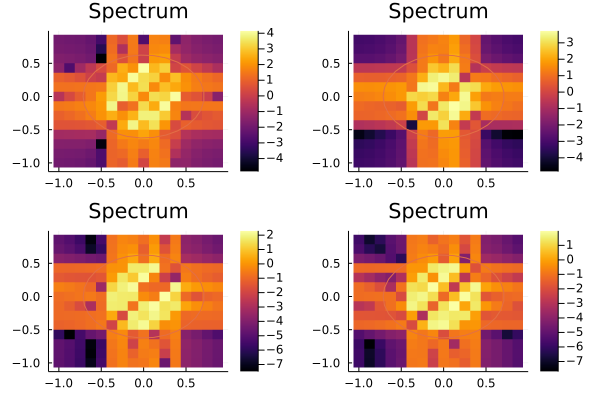

In [14]:
Slep = fftshift(abs2.(fft(sleps[1])))

H9 = heatmap(range(-1.0, 1.0, length=szs[2]+1)[1:szs[2]], range(-1.0, 1.0, length=szs[1]+1)[1:szs[1]], 
    log10.(Slep[:,:,9])) #, clim = (4, -20))
H7 = heatmap(range(-1.0, 1.0, length=szs[2]+1)[1:szs[2]], range(-1.0, 1.0, length=szs[1]+1)[1:szs[1]], 
    log10.(Slep[:,:,7])) #, clim = (4, -20))
H5 = heatmap(range(-1.0, 1.0, length=szs[2]+1)[1:szs[2]], range(-1.0, 1.0, length=szs[1]+1)[1:szs[1]], 
    log10.(Slep[:,:,5])) #, clim = (4, -20))
H3 = heatmap(range(-1.0, 1.0, length=szs[2]+1)[1:szs[2]], range(-1.0, 1.0, length=szs[1]+1)[1:szs[1]], 
    log10.(Slep[:,:,3])) #, clim = (4, -20))

plot!(H9, (Kp/14)*cos.(range(-pi, pi, length=30)), (Kp/16)*sin.(range(-pi, pi, length=30)))
plot!(H7, (Kp/14)*cos.(range(-pi, pi, length=30)), (Kp/16)*sin.(range(-pi, pi, length=30)))
plot!(H5, (Kp/14)*cos.(range(-pi, pi, length=30)), (Kp/16)*sin.(range(-pi, pi, length=30)))
plot!(H3, (Kp/14)*cos.(range(-pi, pi, length=30)), (Kp/16)*sin.(range(-pi, pi, length=30)))

plot(H9, H7, H5, H3, layout = (2,2), title = "Spectrum", legend = false)

# Other shapes 

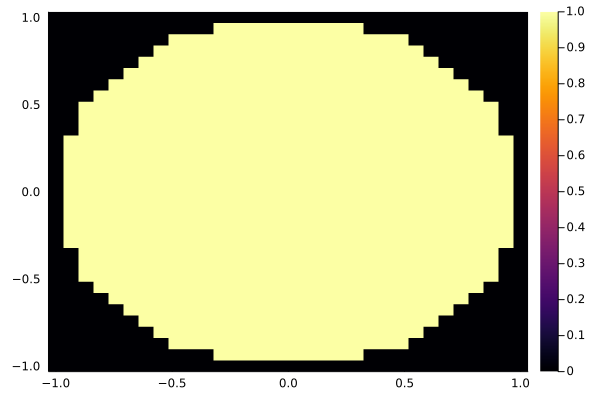

In [9]:
using IterTools
Nx = Ny = 32
x = y = LinRange(-1, 1.0, Nx)
mask = map(x -> (x[1]^2 + x[2]^2 < 1) ? 1.0 : 0.0, IterTools.product(x, y))
heatmap(x, y, mask)

In [25]:
# How to fill this with nodes
M = 4; Kp = 10.0; 
szs = (Nx, Ny)
nowtv = getnodeswts(szs)

# Give any point in the interior, doesn't have to be the center.
c = [0.0, 0.0]
c_ind = [16, 16]

# Find the extent
temp = diff(mask[c_ind[1], :])
lo = findall(temp .> 0.0)
hi = findall(temp .< 0.0)

# Correct all of the segments along that line. 
segs = (lo[1] < hi[1]) ? [x for x in IterTools.product(lo, hi)] : [x for x in IterTools.product(vcat(x[1], lo), vcat(hi, x[end]))] 

scl(x) = (x[2] - x[1])/2
shift(x) = (x[2] + x[1])/2

scl([x[segs[1][1]], x[segs[1][2]]]), shift([x[segs[1][1]], x[segs[1][2]]])

# Fill with nodes
# nowtv[1]*scl(segs[1]) + shift(segs[1])
#no    = [(lbfun(x)*y, x) for x in nowtv[1][1] for y in nowtv[2][1]]

(0.967741935483871, -0.032258064516129004)